In [ ]:
import pandas as pd
import numpy as np
from random import sample
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import glob
import cv2

from google.colab import drive

import matplotlib.pyplot as plt
import keras as ks
from keras import layers
from keras.models import Sequential
import tensorflow as tf
from keras.backend import binary_crossentropy, categorical_crossentropy

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
classes = glob.glob('/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/*')
classes.sort(reverse=False)
classes

['/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/ABE',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/ART',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/BAS',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/BLA',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/EBO',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/EOS',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/FGC',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/HAC',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train_ds/KSC',
 '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_train

In [ ]:
image_size = (250, 250)
batch_size = 32

def get_ds(classes):
    
    name = classes.split('/')[-1]
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(classes, seed=5153, image_size=image_size, batch_size=batch_size)
    val_path = classes.replace('1vR_train_ds', '1vR_validation_ds')
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_path, seed=5153, image_size=image_size, batch_size=batch_size)
    
    train_ds = train_ds.prefetch(buffer_size=batch_size)
    val_ds = val_ds.prefetch(buffer_size=batch_size)
    
    return name, train_ds, val_ds

In [ ]:
def make_model(input_shape, num_classes=2):
    inputs = ks.Input(shape=input_shape)
    x = layers.Rescaling(1.0/255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in (128, 256, 512, 728):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)      
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
        
    return ks.Model(inputs, outputs)

In [ ]:
def train_model(data_set):
  
  #get ds
  name, train_ds, val_ds = get_ds(data_set)
  print('============================', name, '============================')
                
  #set up folder to save model checkpoints
  os.makedirs('/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/{}_model'.format(name), exist_ok=True)
  folder = '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/{}_model'.format(name)
  saved_model = folder + '/model_{epoch}.h5'
  
  #define callbacks
  callbacks = [ks.callbacks.ModelCheckpoint(saved_model, save_best_only=True),
               ks.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
  
  #set up model
  epochs = 50
  model = make_model(image_size+(3,), 2)
  model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
  model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)


In [ ]:
for i in classes:
  train_model(i)

Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
============================ ABE ============================
Epoch 1/50
63/63 [==============================] - 403s 5s/step - loss: 0.2605 - accuracy: 0.9015 - val_loss: 0.7138 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 8s 126ms/step - loss: 0.1090 - accuracy: 0.9670 - val_loss: 0.7669 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 8s 126ms/step - loss: 0.0831 - accuracy: 0.9720 - val_loss: 0.8149 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 9s 128ms/step - loss: 0.0436 - accuracy: 0.9850 - val_loss: 0.9833 - val_accuracy: 0.5000
Epoch 5/50
63/63 [==============================] - 9s 127ms/step - loss: 0.0365 - accuracy: 0.9895 - val_loss: 1.5347 - val_accuracy: 0.5000
Epoch 6/50
63/63 [==============================] - 9s 127ms/step - loss: 0.0432 - accuracy: 0.9885 - val_loss: 0.8157 - val_accuracy: 0.4600
Epoch 

In [ ]:
def get_best_model(classes):
  
  lab = classes.split('/')[-1]
  model = glob.glob('/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/'+lab+'_model/*')
  model = model[-1]

  return ks.models.load_model(model)


In [ ]:
dir = '/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_test_ds'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(dir, shuffle=False, image_size=image_size, batch_size=batch_size)
test_ds = test_ds.prefetch(buffer_size=batch_size)

Found 884 files belonging to 21 classes.


In [ ]:
#test models
n = len(test_ds)
num = 1

result_df = pd.DataFrame()

for image, label in test_ds:
  result = pd.DataFrame({'True':label})
  for i in range(21):
    model = get_best_model(classes[i])
    lab = classes[i].split('/')[-1]
    result[lab + '_preds'] = model.predict(image)
  
  result_df = result_df.append(result).reset_index(drop=True)
  print('{} of {} complete'.format(num, n))
  num += 1

1 of 28 complete
2 of 28 complete
3 of 28 complete
4 of 28 complete
5 of 28 complete
6 of 28 complete
7 of 28 complete
8 of 28 complete
9 of 28 complete
10 of 28 complete
11 of 28 complete
12 of 28 complete
13 of 28 complete
14 of 28 complete
15 of 28 complete
16 of 28 complete
17 of 28 complete
18 of 28 complete
19 of 28 complete
20 of 28 complete
21 of 28 complete
22 of 28 complete
23 of 28 complete
24 of 28 complete
25 of 28 complete
26 of 28 complete
27 of 28 complete
28 of 28 complete


In [ ]:
result_df['Pred'] = np.argmin(np.array(result_df.iloc[:,1:]), axis=-1)

In [ ]:
result_df

,True,ABE_preds,ART_preds,BAS_preds,BLA_preds,EBO_preds,EOS_preds,FGC_preds,HAC_preds,KSC_preds,...,MON_preds,MYB_preds,NGB_preds,NGS_preds,NIF_preds,OTH_preds,PEB_preds,PLM_preds,PMO_preds,Pred
0,0,0.600703,0.135509,0.957611,0.539044,0.998743,0.003574,0.351828,0.667380,0.998169,...,0.910259,0.438788,0.790761,1.000000,0.776194,0.999961,0.999704,0.818322,9.889941e-01,5
1,0,0.600584,0.982590,0.993952,0.482918,0.978635,0.999440,0.329867,0.667206,0.999916,...,0.706824,0.993684,0.990423,1.000000,0.681144,0.992531,0.998385,0.841781,8.729051e-03,20
2,1,0.601515,0.062868,0.589098,0.553151,0.999531,0.927531,0.538313,0.666766,0.017769,...,0.994896,0.997862,0.986979,1.000000,0.481016,0.770037,0.995934,0.998740,9.981396e-01,8
3,1,0.600785,0.013646,0.628774,0.565195,0.999347,0.999949,0.720242,0.667021,0.999940,...,0.965403,0.997169,0.993785,1.000000,0.315827,0.997181,0.998154,0.970116,9.999870e-01,1
4,1,0.599918,0.479822,0.908436,0.539187,0.997614,0.999920,0.478784,0.667057,0.999942,...,0.942941,0.290352,0.733334,0.999980,0.831911,0.998134,0.999426,0.917760,8.087973e-01,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,20,0.600808,0.999999,0.996874,0.623443,0.994567,0.999937,0.646284,0.666693,0.999932,...,0.260870,0.000269,0.612141,0.999999,0.450341,0.979761,0.999998,0.994208,4.294452e-07,20
880,20,0.600844,0.959427,0.964594,0.489859,0.999750,0.999961,0.738060,0.666689,1.000000,...,0.623699,0.675803,0.179606,0.999994,0.269373,0.999976,0.988048,0.998203,4.204320e-05,20
881,20,0.600627,0.999856,0.965926,0.450571,0.999508,0.999805,0.703352,0.666362,1.000000,...,0.928655,0.991070,0.867751,1.000000,0.406048,0.999915,0.936624,0.996582,1.565712e-05,20
882,20,0.601158,0.858155,0.539723,0.741592,0.991436,0.999717,0.571569,0.667550,1.000000,...,0.972284,0.133125,0.050927,0.999998,0.507182,0.999979,0.999979,0.972161,9.886851e-01,11


In [ ]:
accuracy_score(result_df['True'], result_df['Pred'])

0.45475113122171945

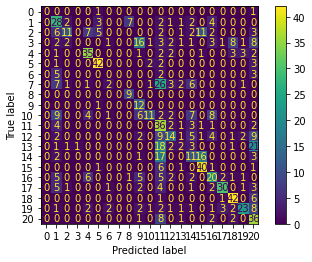

In [ ]:
cm = confusion_matrix(result_df['True'], result_df['Pred'])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
result_df.to_csv('/content/drive/MyDrive/BT5153 Applied ML/Project/BT5153 Applied ML Project /1vR/1vR_21C1k.csv')